# Lab №2

## Выполнение

### 0. Импортируем необходимые библиотеки 

In [1]:
from math import pi
import numpy as np
import roboticstoolbox as rtb
import matplotlib.pyplot as plt
import spatialmath.base as sb

### 1. Импортируем модель Puma560

In [2]:
robot = rtb.models.DH.KR5()
print(robot)

DHRobot: KR5 (by KUKA), 6 joints (RRRRRR), dynamics, geometry, standard DH parameters
┌─────┬────────┬──────┬────────┬─────────┬────────┐
│ θⱼ  │   dⱼ   │  aⱼ  │   ⍺ⱼ   │   q⁻    │   q⁺   │
├─────┼────────┼──────┼────────┼─────────┼────────┤
│  q1 │    0.4 │ 0.18 │ -90.0° │ -155.0° │ 155.0° │
│  q2 │      0 │  0.6 │   0.0° │ -180.0° │  65.0° │
│  q3 │      0 │ 0.12 │  90.0° │  -15.0° │ 158.0° │
│  q4 │  -0.62 │    0 │ -90.0° │ -350.0° │ 350.0° │
│  q5 │      0 │    0 │  90.0° │ -130.0° │ 130.0° │
│  q6 │ -0.115 │    0 │ 180.0° │ -350.0° │ 350.0° │
└─────┴────────┴──────┴────────┴─────────┴────────┘

┌──┬──┐
└──┴──┘

┌──────┬──────┬──────┬──────┬──────┬──────┬──────┐
│ name │ q0   │ q1   │ q2   │ q3   │ q4   │ q5   │
├──────┼──────┼──────┼──────┼──────┼──────┼──────┤
│   qr │  45° │  60° │  45° │  30° │  45° │  30° │
│   qz │  0°  │  0°  │  0°  │  0°  │  0°  │  0°  │
│  qk1 │  45° │  60° │  45° │  30° │  45° │  30° │
│  qk2 │  45° │  60° │  30° │  60° │  45° │  30° │
│  qk3 │  30° │  60

### 2. Зададим начальное положение робота и построим его

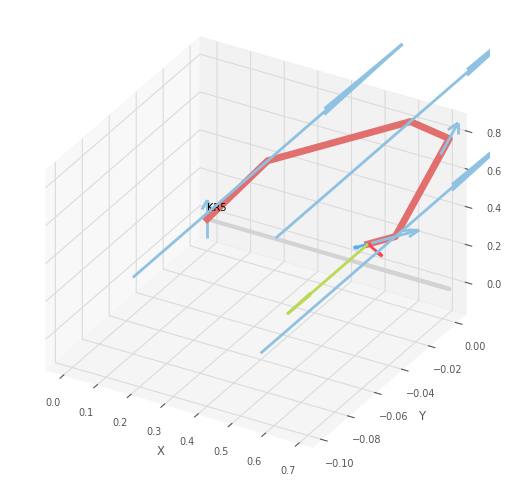

<Figure size 640x480 with 0 Axes>

In [3]:
q_start = [0, -pi/4, pi/3, 0, pi/6, 0]
robot.plot(q_start)
plt.show()

### 3. Решим прямую задачу кинематики

In [4]:
T_start = robot.fkine(q_start)
print(T_start)

   0.7071    0        -0.7071    0.4784    
   0        -1         0         0         
  -0.7071    0        -0.7071    0.113     
   0         0         0         1         



### 6. Построим рабочую зону манипулятора

Инициализируем переменные

In [5]:
print(robot.links[0])

RevoluteDH:   θ=q,  d=0.4,  a=0.18,  ⍺=-1.5707963267948966


In [6]:
limits = [[-2*np.pi, 2*np.pi]] * 6  # For all 6 joints
for i, link in enumerate(robot.links):
    link.qlim = limits[i]

In [7]:
n = 20  # Количество точек по каждой оси
i = 0  # Просто счетчик
move = [np.linspace(robot.links[i].qlim[0], robot.links[i].qlim[1], n) for i in range(3)]  # Записываем пределы перемещения для первых трех звеньев
pose = np.zeros([3,n**3])  # Создаем пустой массив для записи данных


Рассчитываем рабочую зону

In [8]:
# Проходимся перебором по каждой точке
for q1 in move[0]:
    for q2 in move[1]:
        for q3 in move[2]:
            Tt = robot.fkine([q1,q2,q3,0,0,0])  # Решаем ПЗК, меняя только первые 3 обобщенных координаты
            for j in range(3):
                pose[j][i] = Tt.t[j]  # Сохраняем точку
            i += 1

In [9]:
pose

array([[ 9.00000000e-01,  4.23250517e-01,  9.69490630e-02, ...,
         1.52196745e+00,  1.32614320e+00,  9.00000000e-01],
       [ 2.20436424e-16,  9.86897463e-17, -3.08879700e-18, ...,
        -4.13855058e-16, -3.38814462e-16, -2.20436424e-16],
       [-3.35000000e-01, -2.53723800e-01,  1.03240135e-01, ...,
         3.35896199e-01, -1.06312749e-01, -3.35000000e-01]])

Строим рабочую зону

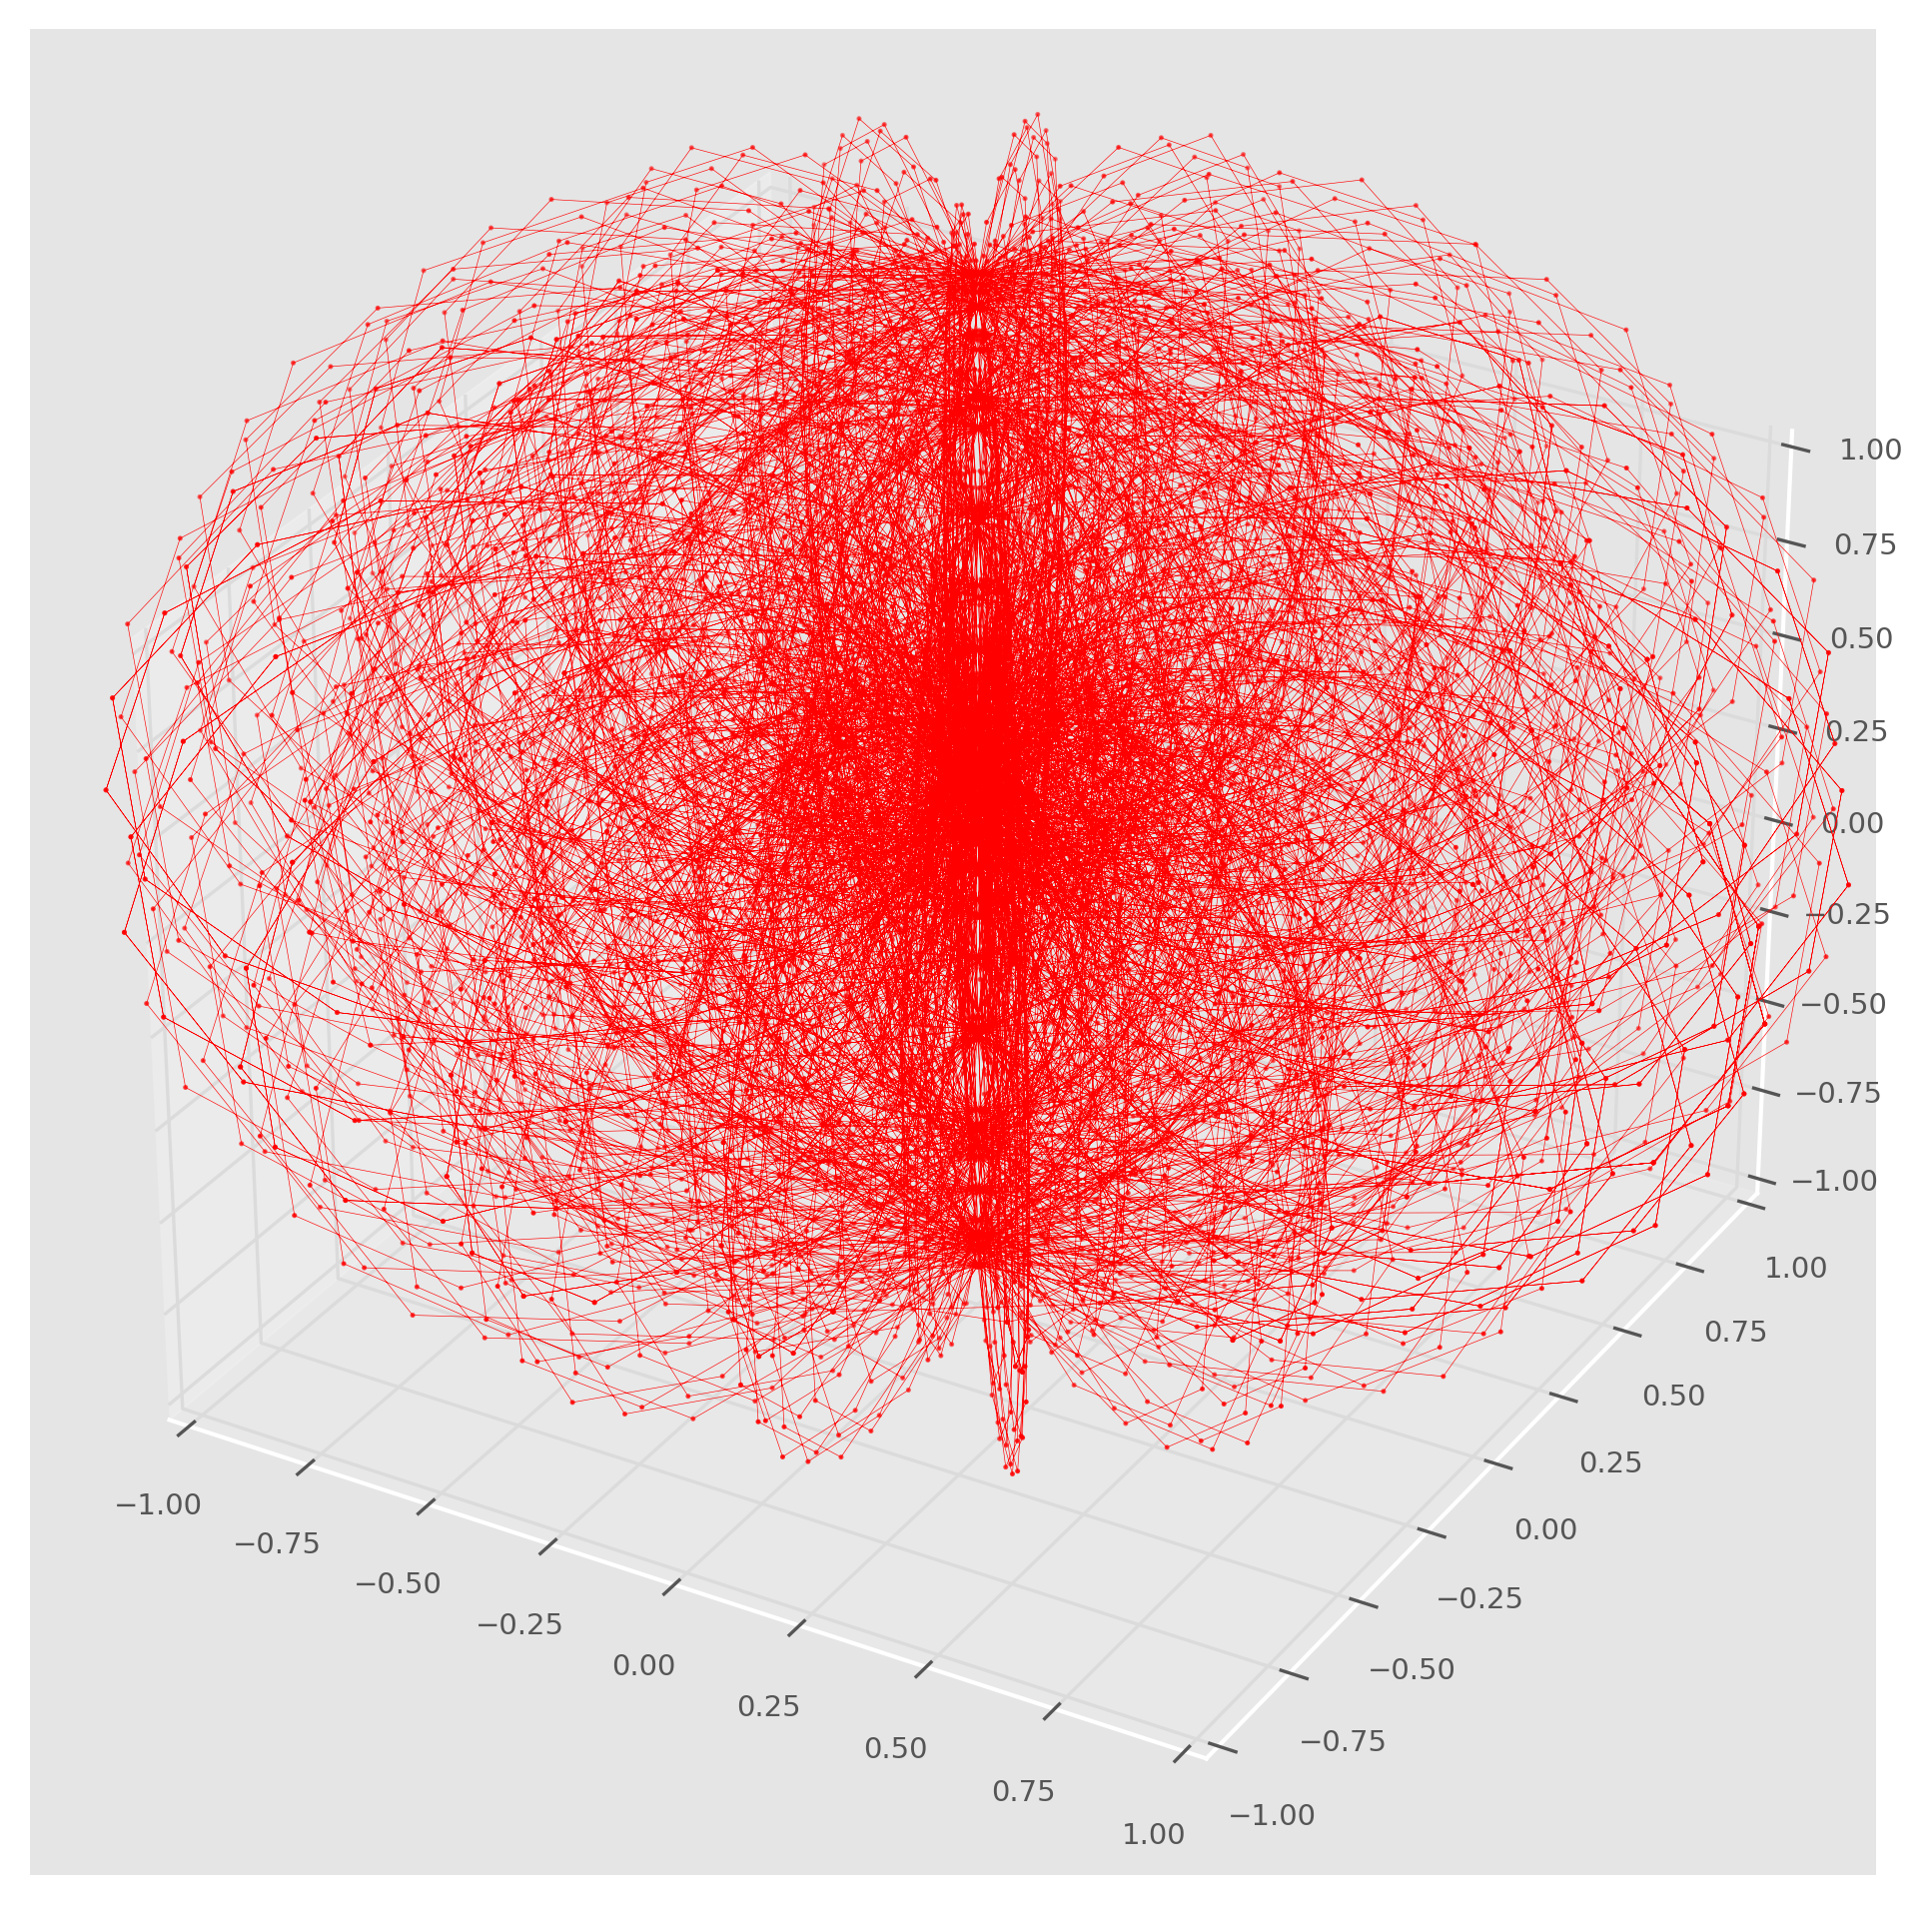

In [10]:
plt.figure(figsize=(8,8), dpi=300)
ax = plt.axes(projection="3d")
ax.plot3D(pose[0], pose[1], pose[2], color='red', linewidth=0.15)
ax.scatter3D(pose[0], pose[1], pose[2], s=0.5, color='red')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
plt.show()

### 7. Выберем конечную точку и проверим её (решим обратную задачу кинематики)

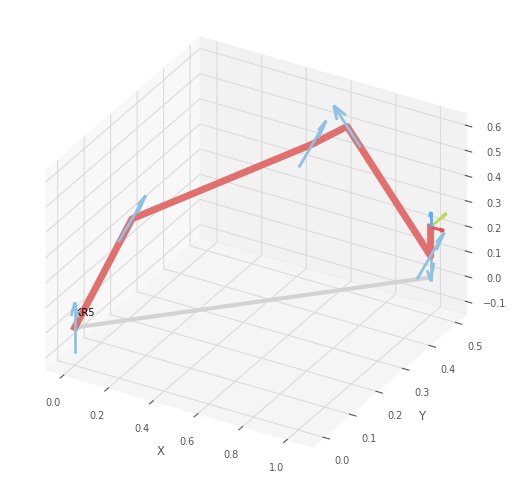

<Figure size 640x480 with 0 Axes>

In [40]:
point = [1,0.5,0.2]
T_end = sb.transl(point)
q_end = robot.ikine_GN(T_end).q  # Есть другие методы, помимо ikine_GN
robot.plot(q_end)
plt.show()

### 8. Спланируем траекторию

Спланируем траекторию методом 'jtraj' для $N$ = 100 точек

In [41]:
N = 100
t_start = 0
t_stop = 5
t_shag = t_stop/N
time = np.arange(t_start, t_stop, t_shag)

tr_jtraj = rtb.jtraj(q_start, q_end, time)

Спланируем ту же траекторию методом 'mtraj' с функцией 'trapezoidal'

In [13]:
tr_trap = rtb.mtraj(rtb.trapezoidal, q_start, q_end, time)

Спланируем ту же траекторию методом 'mtraj' с функцией 'quintic'

In [14]:
tr_quin = rtb.mtraj(rtb.quintic, q_start, q_end, time)

### 9. Построим графики

Построим графики положений для каждого звена

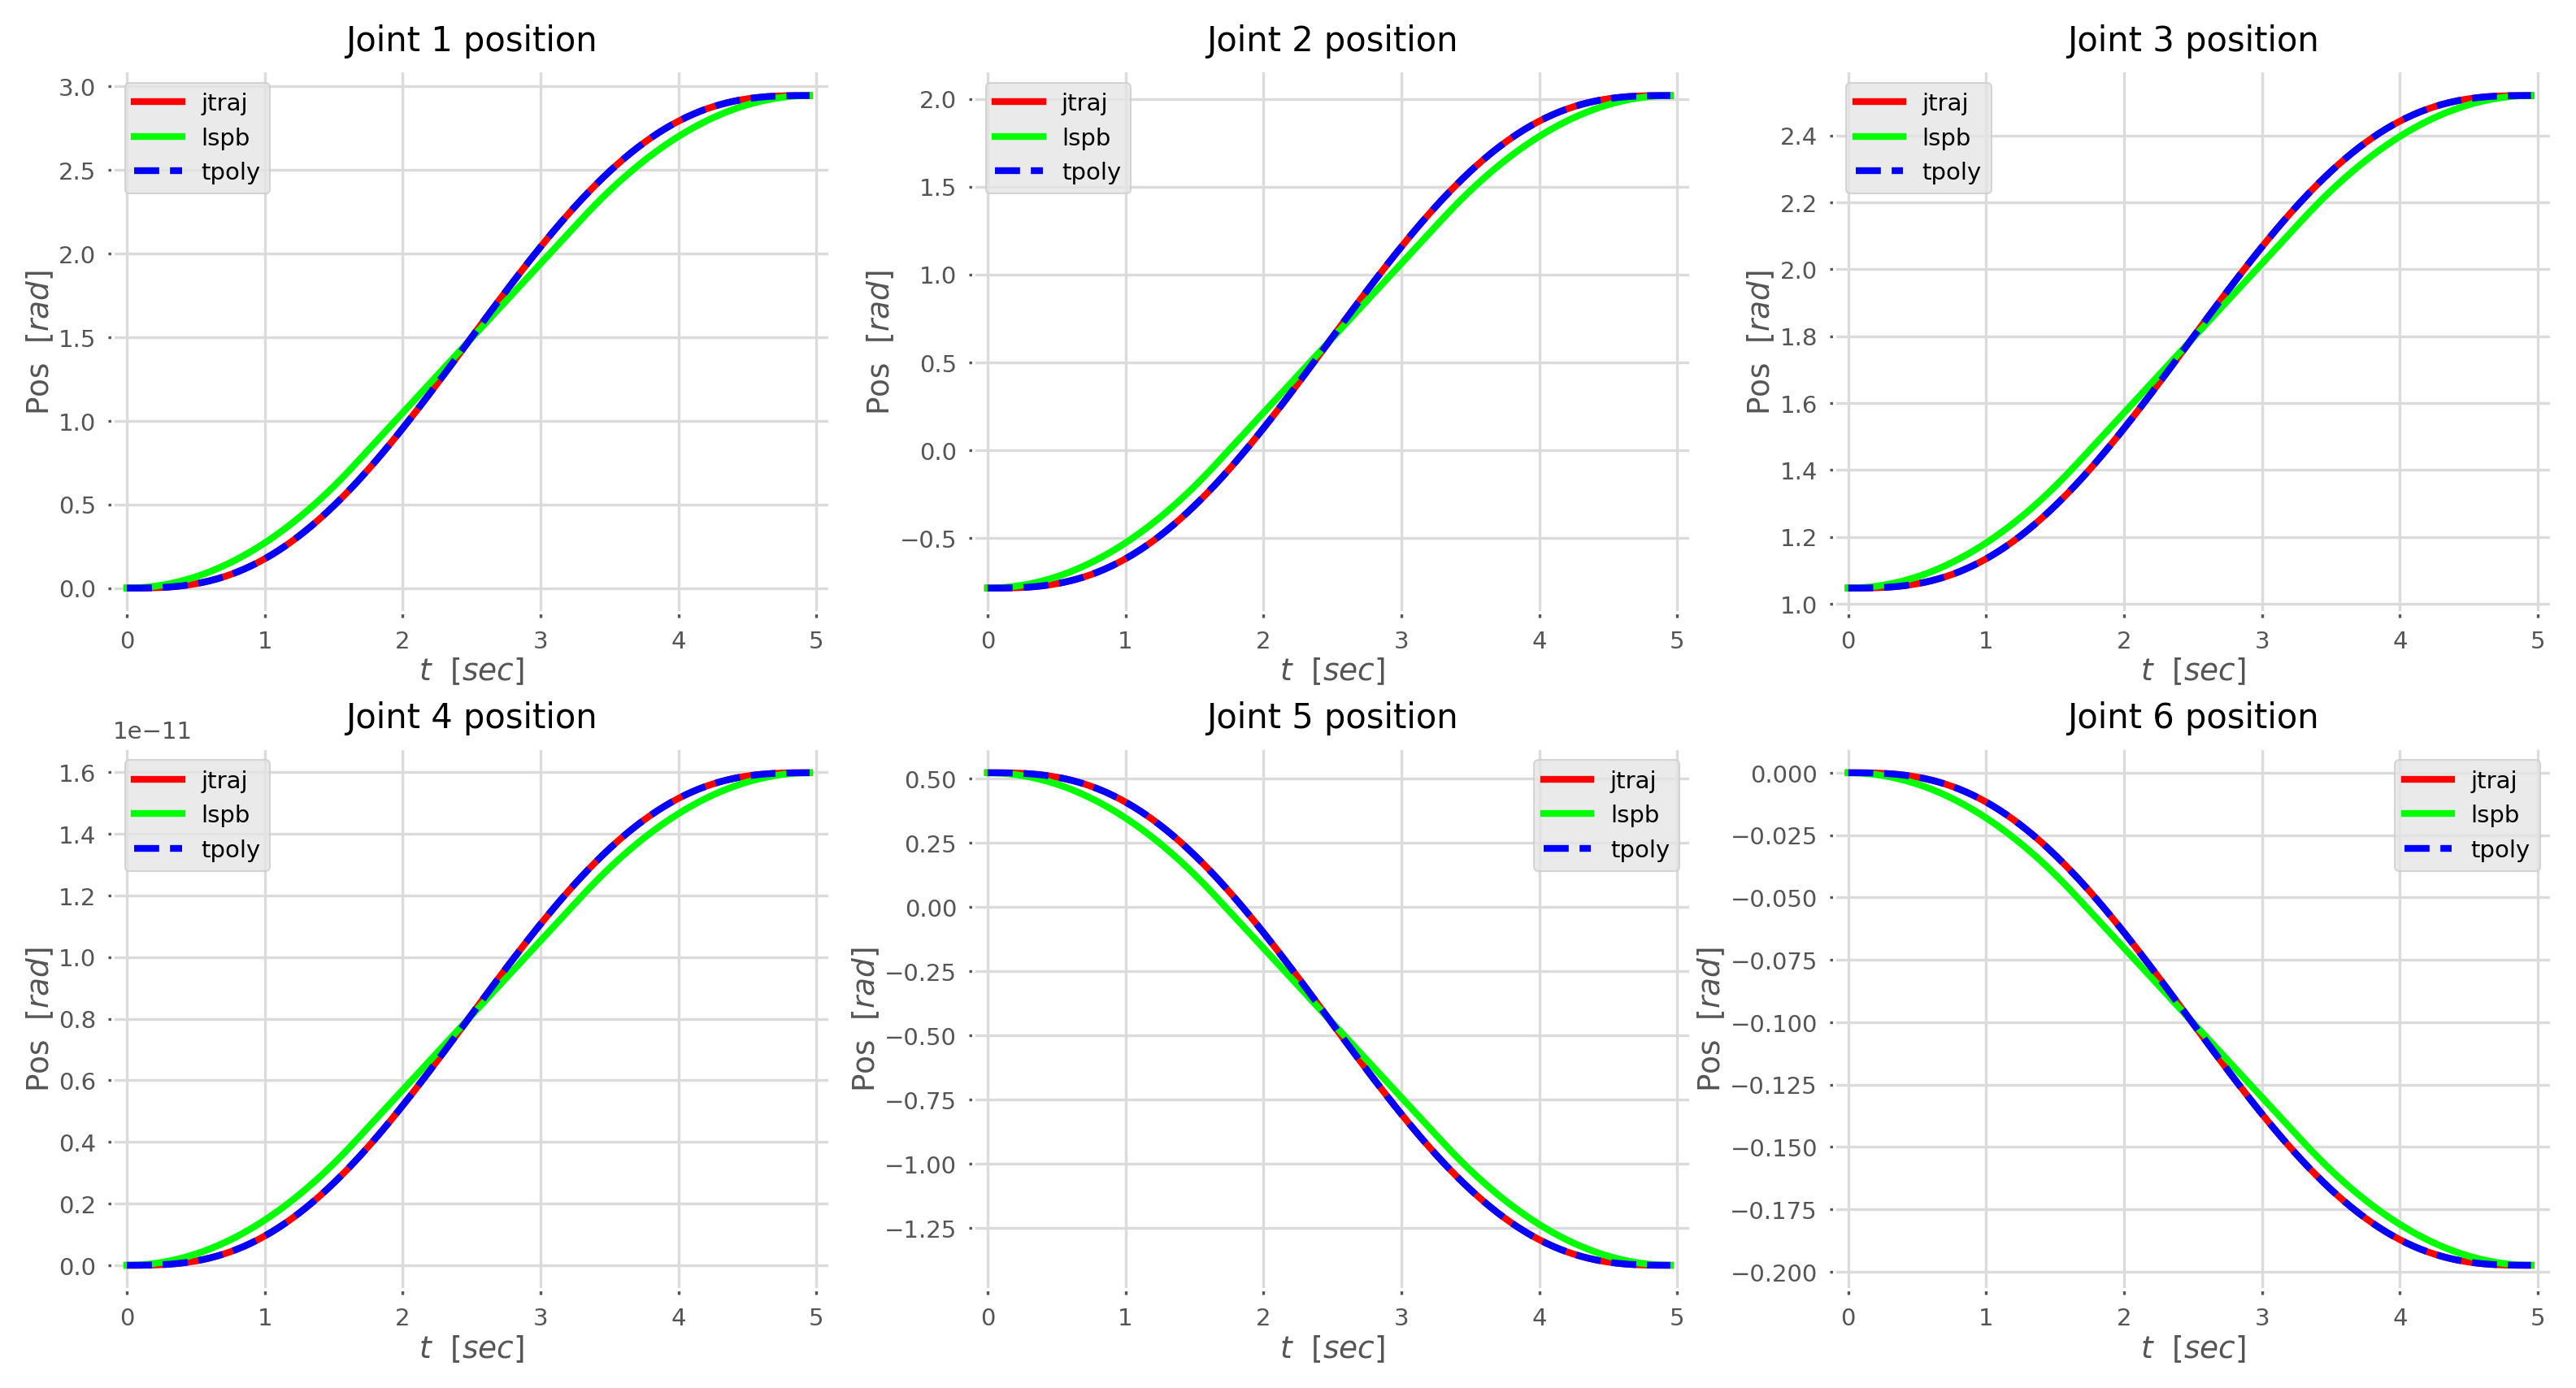

In [38]:
plt.figure(figsize=(10,5), dpi=300)  # Set the figure size and resolution (sharpness of the plot)
for g in range(1,7):
    plt.subplot(2,3,g)
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.25)  # Set spacing between plots to prevent overlap
    traektoriya_jtraj = [tr_jtraj.q[i][g-1] for i in range(len(tr_jtraj.q))]  # Extract the required data
    traektoriya_trap = [tr_trap.q[i][g-1] for i in range(len(tr_trap.q))]  # Extract the required data
    traektoriya_quin = [tr_quin.q[i][g-1] for i in range(len(tr_quin.q))]  # Extract the required data
    plt.plot(time, traektoriya_jtraj, linestyle='-', linewidth=2, color=(1,0,0), label=r"jtraj")  # Draw a line
    plt.plot(time, traektoriya_trap, linestyle='-', linewidth=2, color=(0,1,0), label=r"lspb")  # Draw a line
    plt.plot(time, traektoriya_quin, linestyle='--', linewidth=2, color=(0,0,1), label=r"tpoly")  # Draw a line
    plt.title(r"Joint {} position".format(g), fontsize=10)  # Plot title
    plt.ylabel(r"Pos  [$rad$]", fontsize=9)  # Y-axis label
    plt.xlabel(r"$t$  [$sec$]", fontsize=9)  # X-axis label
    plt.grid(True)  # Add grid
    plt.legend()  # Show legend (displays the labels)
    ax = plt.gca()  # Get current axis to modify
    ax.set_facecolor((1,1,1))  # Set background color of the plot
    ax.set_xlim([t_start-0.1,t_stop+0.1])  # Set limits on the X-axis
plt.show()

Построим графики скоростей для каждого звена

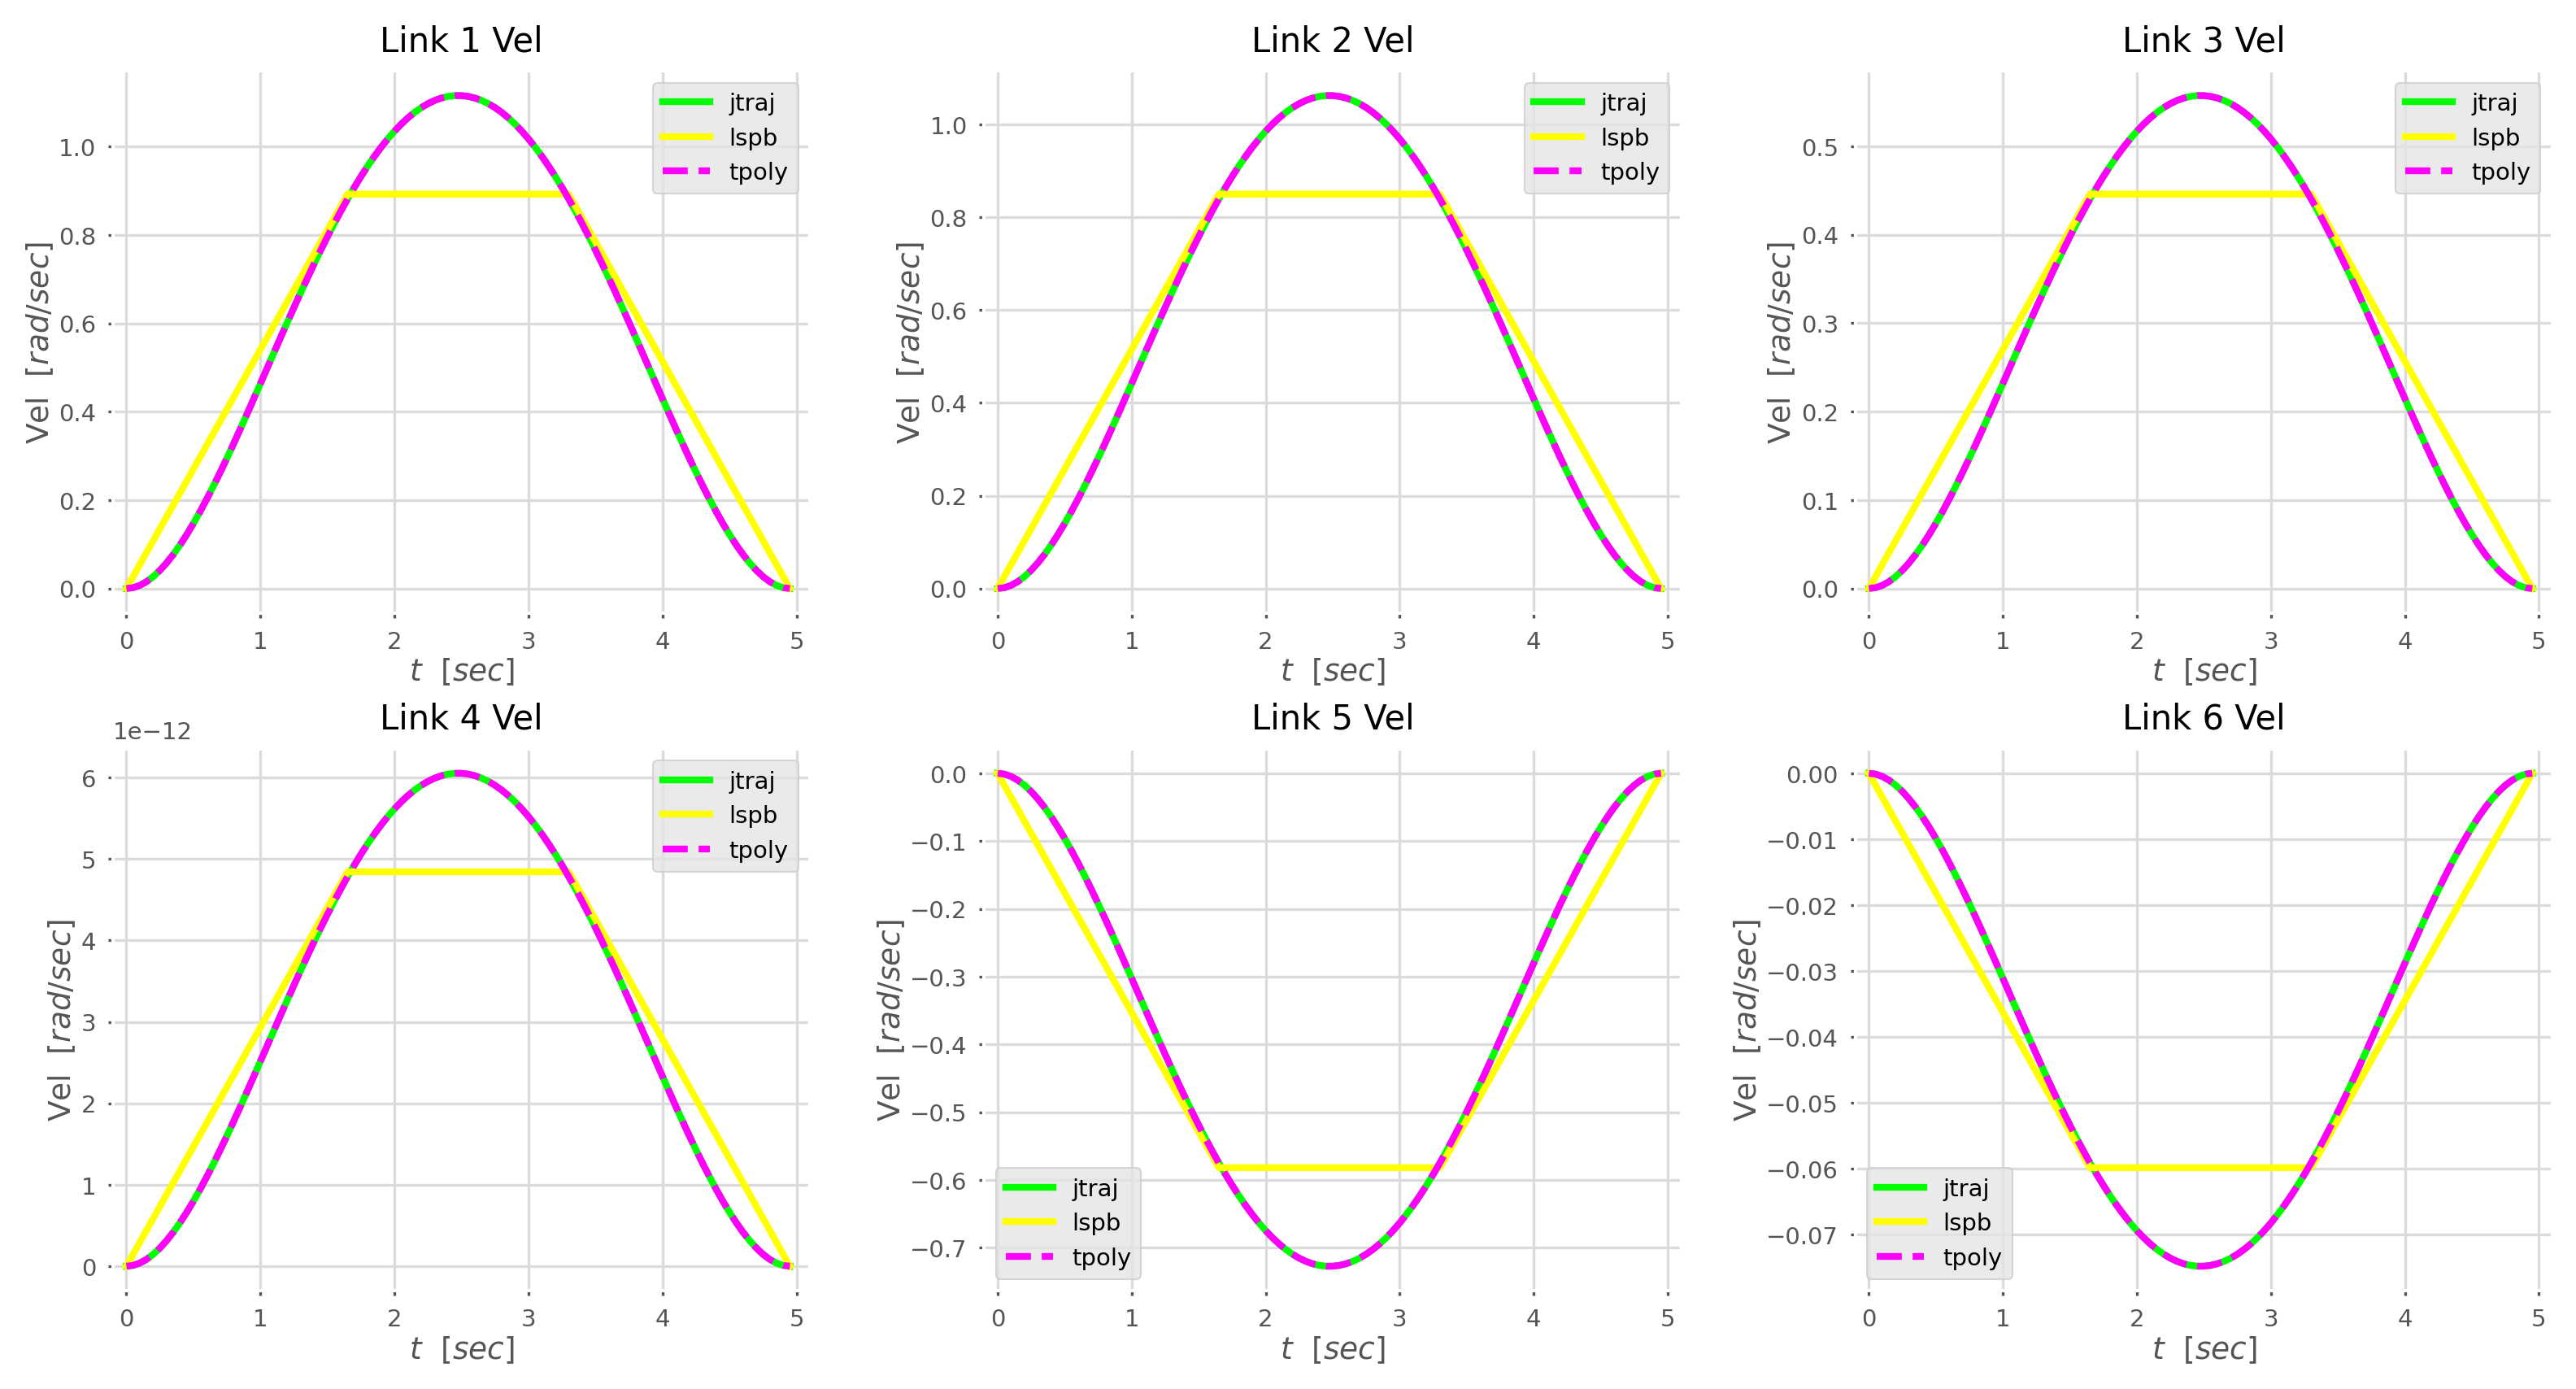

In [37]:
plt.figure(figsize=(10,5), dpi=300)  # Set the canvas size and point density (plot clarity)
for g in range(1,7):
    plt.subplot(2,3,g)
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.25, hspace=0.25)  # Set spacing between plots to prevent overlap
    traektoriya_jtraj = [tr_jtraj.qd[i][g-1] for i in range(len(tr_jtraj.qd))]  # Extract the required data
    traektoriya_trap = [tr_trap.qd[i][g-1] for i in range(len(tr_trap.qd))]  # Extract the required data
    traektoriya_quin = [tr_quin.qd[i][g-1] for i in range(len(tr_quin.qd))]  # Extract the required data
    plt.plot(time, traektoriya_jtraj, linestyle='-', linewidth=2, color=(0,1,0), label=r"jtraj")  # Draw a line
    plt.plot(time, traektoriya_trap, linestyle='-', linewidth=2, color=(1,1,0), label=r"lspb")  # Draw a line
    plt.plot(time, traektoriya_quin, linestyle='--', linewidth=2, color=(1,0,1), label=r"tpoly")  # Draw a line
    plt.title(r"Link {} Vel".format(g), fontsize=10)  # Plot title
    plt.ylabel(r"Vel  [$rad/sec$]", fontsize=9)  # Y-axis label
    plt.xlabel(r"$t$  [$sec$]", fontsize=9)  # X-axis label
    plt.grid(True)  # Add grid
    plt.legend()  # Show legend
    ax = plt.gca()  # Get current axis for modification
    ax.set_facecolor((1,1,1))  # Set plot background color
    ax.set_xlim([t_start-0.1,t_stop+0.1])  # Set X-axis limits
plt.show()

Построим графики ускорений для каждого звена

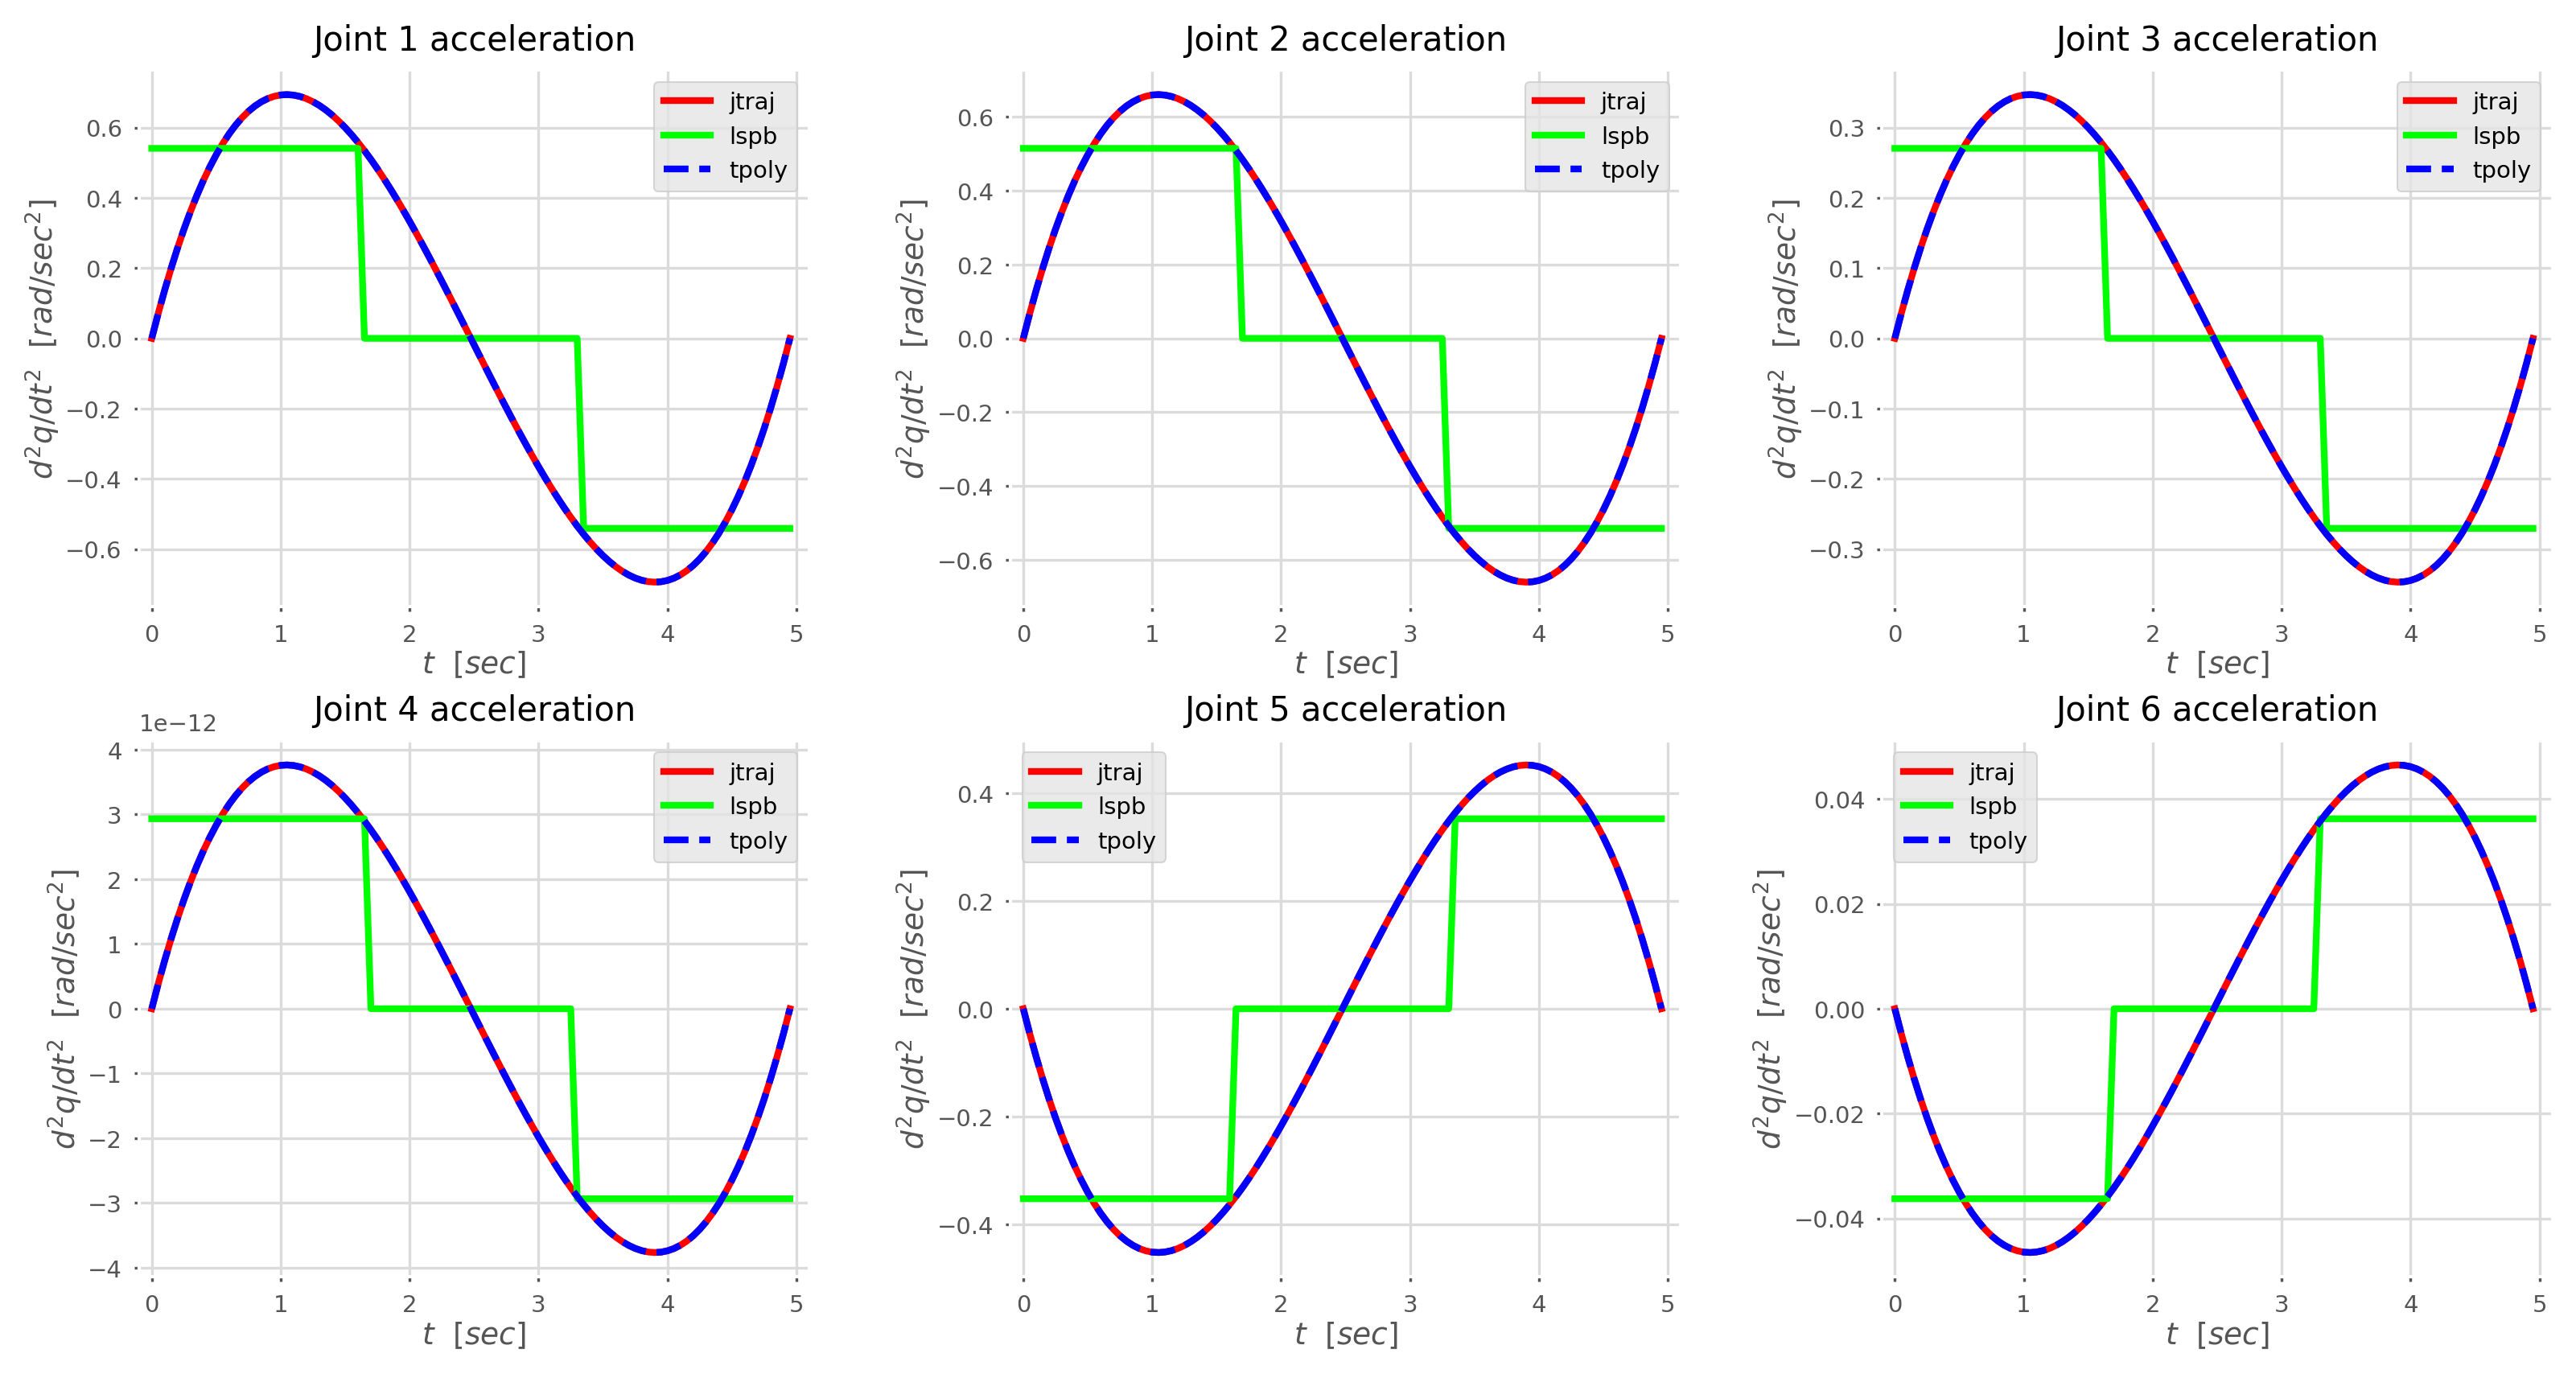

In [ ]:
fig = plt.figure(figsize=(10,5), dpi=300)  # Set the figure size and resolution (sharpness of the plot)
for g in range(1,7):
    plt.subplot(2,3,g)
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.25)  # Set the spacing between the subplots to prevent overlap
    traektoriya_jtraj = [tr_jtraj.qdd[i][g-1] for i in range(len(tr_jtraj.qdd))]  # Extract the required data
    traektoriya_trap = [tr_trap.qdd[i][g-1] for i in range(len(tr_trap.qdd))]  # Extract the required data
    traektoriya_quin = [tr_quin.qdd[i][g-1] for i in range(len(tr_quin.qdd))]  # Extract the required data
    plt.plot(time, traektoriya_jtraj, linestyle='-', linewidth=2, color=(1,0,0), label=r"jtraj")  # Draw a line
    plt.plot(time, traektoriya_trap, linestyle='-', linewidth=2, color=(0,1,0), label=r"lspb")  # Draw a line
    plt.plot(time, traektoriya_quin, linestyle='--', linewidth=2, color=(0,0,1), label=r"tpoly")  # Draw a line
    plt.title(r"Joint {} acceleration".format(g), fontsize=10)  # Plot title
    plt.ylabel(r"Acc  [$rad/{sec}^2$]", fontsize=9)  # Y-axis label
    plt.xlabel(r"$t$  [$sec$]", fontsize=9)  # X-axis label
    plt.grid(True)  # Add grid
    plt.legend()  # Show legend (displays the labels)
    ax = plt.gca()  # Get the current axis to modify it
    ax.set_facecolor((1,1,1))  # Set background color of the plot
    ax.set_xlim([t_start-0.1,t_stop+0.1])  # Set limits on the X-axis
plt.show()